In [1]:
import sys, pathlib
module_path = pathlib.Path("__file__").resolve().parent
sys.path.insert(0, str(module_path))

### Define the MLP architecture

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    def __init__(self, 
                 num_features, 
                 num_classes, 
                 num_hidden_layers, 
                 hidden_layer_neurons, 
                 dropout_prob,
                 use_edge_weights=False
                ):
        
        super().__init__()
        self.use_edge_weights = use_edge_weights

        # Input layer
        layers = [nn.Linear(num_features, 
                            hidden_layer_neurons[0]), 
                  nn.ReLU(), 
                  nn.Dropout(p=dropout_prob)]

        # Hidden layers
        for i in range(num_hidden_layers - 1):
            layers.extend([nn.Linear(hidden_layer_neurons[i], 
                                     hidden_layer_neurons[i + 1]), 
                           nn.ReLU(), 
                           nn.Dropout(p=dropout_prob)])

        # Output layer
        layers.append(nn.Linear(hidden_layer_neurons[-1], 
                                num_classes))

        self.layers = nn.Sequential(*layers)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        if self.use_edge_weights and hasattr(data, 'edge_weight'):
            edge_weight = data.edge_weight.view(-1, 1)
            x = x * edge_weight

        output = self.layers(x)
        return output

### Load the data

In [3]:
from mof_galaxy.main import get_data


# Check if GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_graph, val_graph, test_graph = get_data(device, 
                                              num_val=0.2, 
                                              num_test=0.0, 
                                              alpha=0.9, 
                                              omega=0.9)

### Train the MLP model and plot the results

Epoch 500/2000 (learning rate: 1.902e-02)
----------------------------------------------------------
Loss [Train, Val]: [1.098, 1.084] 	 Accuracy [Train, Val]: [0.538, 0.548]

Epoch 999/2000 (learning rate: 1.827e-02)
----------------------------------------------------------
Loss [Train, Val]: [1.076, 1.071] 	 Accuracy [Train, Val]: [0.543, 0.548]

Epoch 1498/2000 (learning rate: 1.737e-02)
----------------------------------------------------------
Loss [Train, Val]: [1.072, 1.062] 	 Accuracy [Train, Val]: [0.544, 0.549]

Epoch 1997/2000 (learning rate: 1.652e-02)
----------------------------------------------------------
Loss [Train, Val]: [1.076, 1.056] 	 Accuracy [Train, Val]: [0.545, 0.553]



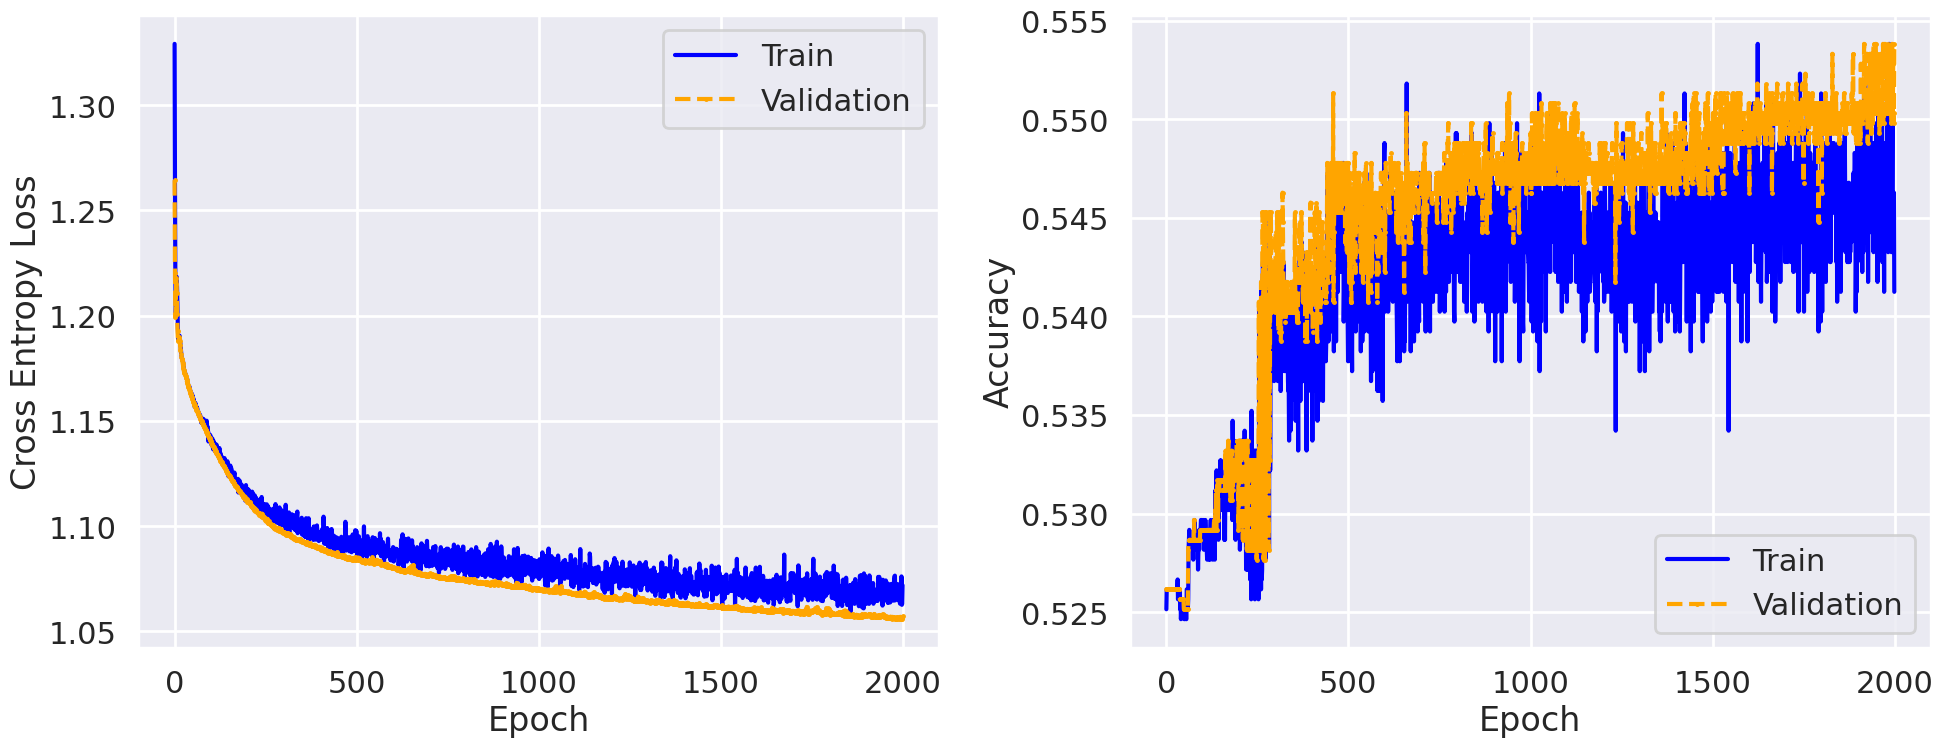

In [4]:
from mof_galaxy.main import train, plot_results
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme("poster")


model = MLP(num_features=train_graph.x.shape[1], 
            num_classes=len(train_graph.y.unique()),
            dropout_prob=0.01,
            num_hidden_layers=1,
            hidden_layer_neurons=[32]
            ).to(device)

trained_model, stats = train(model,
                             train_graph=train_graph,
                             val_graph=val_graph,
                             num_epochs=2000,
                             batch_size=16, 
                             lr=0.02, 
                             lr_step=100, 
                             lr_gamma=0.99, 
                             display_freq=500
                            )

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
axes[0], axes[1] = plot_results(ax_loss=axes[0], ax_acc=axes[1], model_stats=stats)
plt.tight_layout()

### Hyperparameter Tuning with Optuna

#### a) Tuning number of hidden layers, hidden neurons and dropout probability in each layer 

In [5]:
%%time

import optuna

# Define the objective function for Optuna optimization
def objective_layers(trial):
    # Suggest hyperparameters to be optimized
    num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 3)
    hidden_layer_neurons = []
    possible_neuron_sizes = [16, 32, 64]
    for i in range(num_hidden_layers):
        num_neurons = trial.suggest_categorical(f"neurons_{i+1}", possible_neuron_sizes)
        hidden_layer_neurons.append(num_neurons)
    dropout_prob = lr = trial.suggest_float('dropout_prob', 1e-3, 1e-1, log=True)
    
    # Train the model with suggested hyperparameters
    model = MLP(num_features=train_graph.x.shape[1], 
                num_classes=len(train_graph.y.unique()),
                dropout_prob=dropout_prob,
                num_hidden_layers=num_hidden_layers,
                hidden_layer_neurons=hidden_layer_neurons
               ).to(device)

    trained_model, stats = train(model,
                                 train_graph=train_graph,
                                 val_graph=val_graph,
                                 num_epochs=5000,
                                 batch_size=16, 
                                 lr=0.02, 
                                 lr_step=100, 
                                 lr_gamma=0.99, 
                                 display_freq=5001
                                )

    # Return the validation accuracy as the objective value to be maximized
    return stats['val']['accuracy'][-1]

# Perform Optuna study
study1 = optuna.create_study(direction='maximize')
study1.optimize(objective_layers, n_trials=15)

[I 2023-12-15 21:07:54,873] A new study created in memory with name: no-name-74009093-540a-4dcf-8ad7-43224318ddb4
[I 2023-12-15 21:08:36,281] Trial 0 finished with value: 0.6322937625754527 and parameters: {'num_hidden_layers': 3, 'neurons_1': 16, 'neurons_2': 32, 'neurons_3': 32, 'dropout_prob': 0.0035798595370840625}. Best is trial 0 with value: 0.6322937625754527.
[I 2023-12-15 21:09:16,518] Trial 1 finished with value: 0.6871227364185111 and parameters: {'num_hidden_layers': 3, 'neurons_1': 32, 'neurons_2': 64, 'neurons_3': 64, 'dropout_prob': 0.00249932488462583}. Best is trial 1 with value: 0.6871227364185111.
[I 2023-12-15 21:09:50,990] Trial 2 finished with value: 0.573943661971831 and parameters: {'num_hidden_layers': 1, 'neurons_1': 64, 'dropout_prob': 0.09815527946330029}. Best is trial 1 with value: 0.6871227364185111.
[I 2023-12-15 21:10:24,714] Trial 3 finished with value: 0.5437625754527163 and parameters: {'num_hidden_layers': 1, 'neurons_1': 32, 'dropout_prob': 0.00145

CPU times: user 8min 50s, sys: 50.9 s, total: 9min 41s
Wall time: 9min 44s


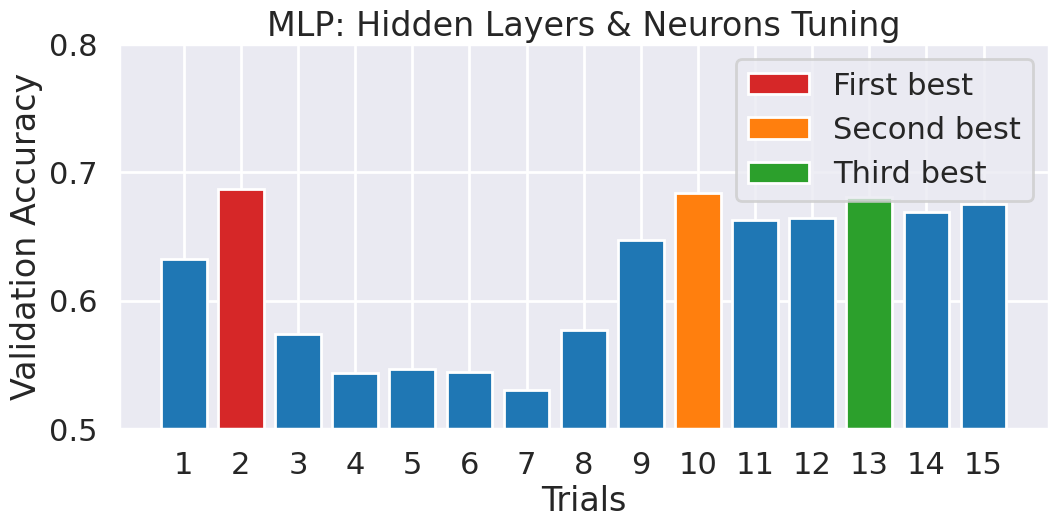

In [6]:
study1_df = study1.trials_dataframe()
study1_df_sort = study1_df.sort_values(by="value", ascending=False).reset_index()
top_three_expts = study1_df_sort["number"].to_numpy()[:3]

fig, ax = plt.subplots(figsize=(12,5))
x_values = [str(i+1) for i in study1_df["number"]]
bar_labels = []
bar_colors = []
for i in range(len(x_values)):
    if i == top_three_expts[0]:
        bar_labels.append("First best")
        bar_colors.append("tab:red")
    elif i == top_three_expts[1]:
        bar_labels.append("Second best")
        bar_colors.append("tab:orange")
    elif i == top_three_expts[2]:
        bar_labels.append("Third best")
        bar_colors.append("tab:green")
    else:
        bar_labels.append("_")
        bar_colors.append("tab:blue")

ax.bar(x_values, study1_df["value"], label=bar_labels, color=bar_colors)
ax.set_xlabel("Trials")
ax.set_ylabel("Validation Accuracy")
ax.set_ylim([0.5, 0.8])
ax.set_title("MLP: Hidden Layers & Neurons Tuning")
ax.legend()

In [8]:
# Get the top 3 best hyperparameters from Study 1
for i, text in enumerate(["First", "Second", "Third"]):
    acc = study1_df_sort.value.iloc[i]
    if i == 0:
        print(f"\n\nFirst Best (val. acc. = {acc:.3f})")
    elif i == 1:
        print(f"\n\nSecond Best (val. acc. = {acc:.3f})")
    elif i == 2:
        print(f"\n\nThird Best (val. acc. = {acc:.3f})")
    print(f"----------------------------------")
    j = study1_df_sort.number.iloc[i]
    for param_name, param_value in study1.trials[j].params.items():
        if isinstance(param_value, float):
            print(f"{param_name} : {param_value:.3e}")
        else:
            print(f"{param_name} : {param_value}")



First Best (val. acc. = 0.687)
----------------------------------
num_hidden_layers : 3
neurons_1 : 32
neurons_2 : 64
neurons_3 : 64
dropout_prob : 2.499e-03


Second Best (val. acc. = 0.684)
----------------------------------
num_hidden_layers : 3
neurons_1 : 32
neurons_2 : 32
neurons_3 : 64
dropout_prob : 1.446e-03


Third Best (val. acc. = 0.681)
----------------------------------
num_hidden_layers : 3
neurons_1 : 32
neurons_2 : 64
neurons_3 : 64
dropout_prob : 2.522e-03


#### b) Tuning batch sizes and learning rate parameters

**Model architecture** (from above study):

- num_hidden_layers : 3
- neurons_1 : 32
- neurons_2 :  64
- neurons_3 :  64- dropout_prob : 2.499e-03

In [9]:
%%time

# Define the objective function for Optuna optimization
def objective_learn(trial):
    # Suggest hyperparameters to be optimized
    batch_size = trial.suggest_int('batch_size', 4, 256)
    lr = trial.suggest_float('lr', 1e-4, 0.1, log=True)
    lr_step = trial.suggest_int('lr_step', 50, 500)
    lr_gamma = trial.suggest_float('lr_gamma', 0.9, 1.0)
   
    # Train the model with suggested hyperparameters
    model = MLP(num_features=train_graph.x.shape[1], 
                num_classes=len(train_graph.y.unique()),
                dropout_prob=2.499e-03,
                num_hidden_layers=3,
                hidden_layer_neurons=[32, 64, 64]
               ).to(device)

    trained_model, stats = train(model,
                                 train_graph=train_graph,
                                 val_graph=val_graph,
                                 num_epochs=5000,
                                 batch_size=batch_size, 
                                 lr=lr, 
                                 lr_step=lr_step, 
                                 lr_gamma=lr_gamma, 
                                 display_freq=5001
                                )

    # Return the validation accuracy as the objective value to be maximized
    return stats['val']['accuracy'][-1]

# Perform Optuna study
study2 = optuna.create_study(direction='maximize')
study2.optimize(objective_learn, n_trials=20)

[I 2023-12-15 21:22:05,058] A new study created in memory with name: no-name-d6e4fa16-e5be-482b-be25-c9e65183c78f
[I 2023-12-15 21:22:32,936] Trial 0 finished with value: 0.5261569416498993 and parameters: {'batch_size': 164, 'lr': 0.09973206506506711, 'lr_step': 153, 'lr_gamma': 0.9258338965505928}. Best is trial 0 with value: 0.5261569416498993.
[I 2023-12-15 21:23:01,548] Trial 1 finished with value: 0.6891348088531187 and parameters: {'batch_size': 181, 'lr': 0.005331794937060081, 'lr_step': 295, 'lr_gamma': 0.9477568392871943}. Best is trial 1 with value: 0.6891348088531187.
[I 2023-12-15 21:23:29,417] Trial 2 finished with value: 0.6011066398390342 and parameters: {'batch_size': 23, 'lr': 0.04630146314493499, 'lr_step': 213, 'lr_gamma': 0.9258824436603793}. Best is trial 1 with value: 0.6891348088531187.
[I 2023-12-15 21:23:56,097] Trial 3 finished with value: 0.6851106639839034 and parameters: {'batch_size': 206, 'lr': 0.011876212630824461, 'lr_step': 475, 'lr_gamma': 0.94648499

CPU times: user 8min 24s, sys: 56.7 s, total: 9min 21s
Wall time: 9min 23s


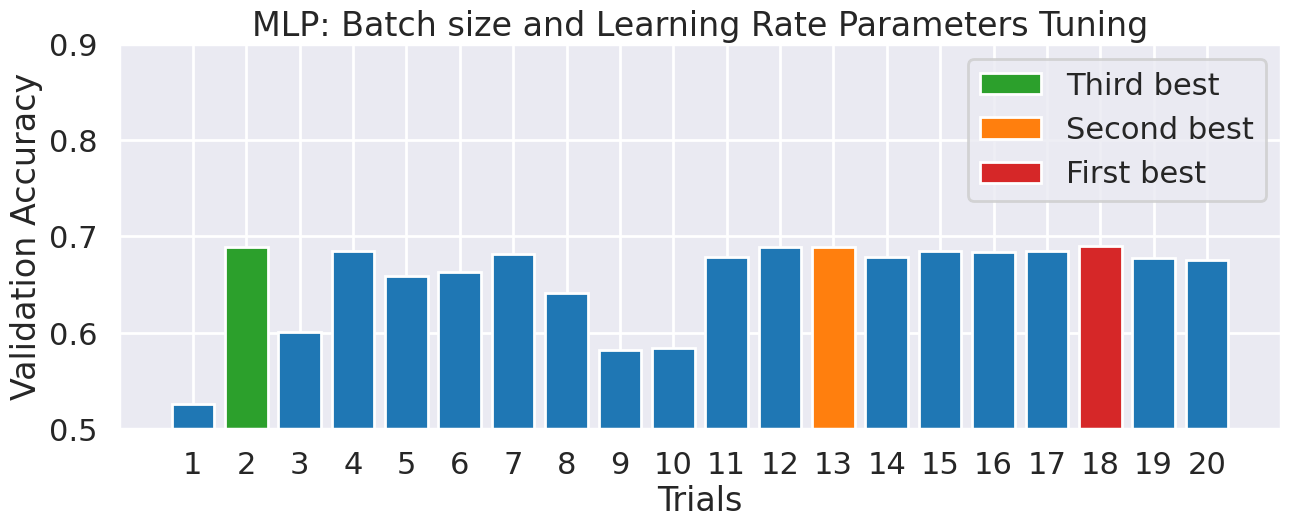

In [10]:
study2_df = study2.trials_dataframe()
study2_df_sort = study2_df.sort_values(by="value", ascending=False).reset_index()
top_three_expts = study2_df_sort["number"].to_numpy()[:3]

fig, ax = plt.subplots(figsize=(15,5))
x_values = [str(i+1) for i in study2_df["number"]]
bar_labels = []
bar_colors = []
for i in range(len(x_values)):
    if i == top_three_expts[0]:
        bar_labels.append("First best")
        bar_colors.append("tab:red")
    elif i == top_three_expts[1]:
        bar_labels.append("Second best")
        bar_colors.append("tab:orange")
    elif i == top_three_expts[2]:
        bar_labels.append("Third best")
        bar_colors.append("tab:green")
    else:
        bar_labels.append("_")
        bar_colors.append("tab:blue")

ax.bar(x_values, study2_df["value"], label=bar_labels, color=bar_colors)
ax.set_xlabel("Trials")
ax.set_ylabel("Validation Accuracy")
ax.set_ylim([0.5, 0.9])
ax.set_title("MLP: Batch size and Learning Rate Parameters Tuning")
ax.legend()

In [11]:
# Get the top 3 best hyperparameters from Study 2
for i, text in enumerate(["First", "Second", "Third"]):
    acc = study2_df_sort.value.iloc[i]
    if i == 0:
        print(f"\n\nFirst Best (val. acc. = {acc:.5f})")
    elif i == 1:
        print(f"\n\nSecond Best (val. acc. = {acc:.5f})")
    elif i == 2:
        print(f"\n\nThird Best (val. acc. = {acc:.5f})")
    print(f"----------------------------------")
    j = study2_df_sort.number.iloc[i]
    for param_name, param_value in study2.trials[j].params.items():
        if isinstance(param_value, float):
            print(f"{param_name} : {param_value:.3e}")
        else:
            print(f"{param_name} : {param_value}")



First Best (val. acc. = 0.68964)
----------------------------------
batch_size : 228
lr : 5.281e-03
lr_step : 297
lr_gamma : 9.646e-01


Second Best (val. acc. = 0.68913)
----------------------------------
batch_size : 176
lr : 8.979e-03
lr_step : 375
lr_gamma : 9.668e-01


Third Best (val. acc. = 0.68913)
----------------------------------
batch_size : 181
lr : 5.332e-03
lr_step : 295
lr_gamma : 9.478e-01


### Final MLP Model

From above studies, we have

**Model architecture**:

- num_hidden_layers : 3
- neurons_1 : 32
- neurons_2 :  64
- neurons_3 :  64
- dropout_prob : 2.499e-03
  
**Training**:

- batch_size : 228- lr : 5.281e-03
- lr_step : 297 
- 
lr_gamma : 9.646e-01